# TP : PREDICTION DES MOUVEMENTS DANS LES PARTIES D'ECHECS AVEC CNN

---



Dans ce TP, nous allons explorer l'utilisation des réseaux de neurones convolutionnels (CNN) pour prédire les mouvements dans les parties d'échecs. Nous allons développer un modèle CNN capable de prendre en compte l'état actuel de l'échiquier et de suggérer les mouvements suivants possibles ( prise de décision du prochain déplacement).

* **Importation et prétraitement des données**
* **Construction du modèle CNN**
* **Entraînement du modèle**
* **Test du modèle**



---



J'ai travaillé sur Google Colab pour bénéficier de la puissance de calcul disponible et ainsi entraîner le modèle plus rapidement.


La première etape faut d'abord importer le fichier kaggle.json afin de pouvoir télécharger les jeux de données directement depuis Kaggle.


In [ ]:
from google.colab import files

# Choose the file from your local machine
uploaded = files.upload()

Saving kaggle.json to kaggle.json


J'ai installé les bibliothèques nécessaires, et je me suis placé dans le répertoire correspondant, puis téléchargé le jeu de données et décompressé.

In [ ]:
!pip install chess -q
!pip install kaggle -q

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download arevel/chess-games

#unzip
!unzip -qq /content/chess-games.zip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 4.8 MB/s eta 0:00:00
 99% 1.44G/1.45G [00:16<00:00, 78.2MB/s]
100% 1.45G/1.45G [00:16<00:00, 93.4MB/s]


Le jeu de données sur kaggle contient des informations sur 6,25 millions de parties d'échecs jouées sur lichess.org en juillet 2016

In [ ]:
import pandas as pd
import numpy as np
import chess
import re
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
import csv
import itertools

Ici j'ai crée deux dictionnaires qui simplifieront la conversion entre la représentation matricielle et la représentation de l'échiquier lors de la manipulation des coordonnées dans le code.

In [ ]:
letter_2_num = {'a':0,'b':1,'c':2,'d':3,'e':4,'f':5,'g':6,'h':7}
num_2_letter = {0:'a',1:'b',2:'c',3:'d', 4:'e',5:'f', 6:'g', 7:'h'}

# CHOIX DE LA REPRESENTATION DU BOARD

On peut maintenant aborder l'un des principaux défis pour entraîner un CNN c'est celui de la représentation d'un échiquier : un CNN ne peut généralement accepter que des tenseurs 2D ou des matrices 3D qui ne contiennent que des nombres. Comment pouvons-nous alors convertir la notion d'une pièce d'échecs en un objet mathématique ?

Une approche possible consiste à attribuer un numéro unique à chaque pièce d'échecs.

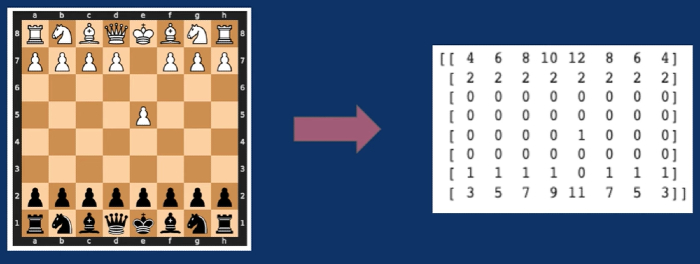

Sauf qu'attribuer simplement des valeurs numériques aux pièces ne reflète pas efficacement la relation entre les pièces d'une manière propice à l'apprentissage. Par exemple, en attribuant une valeur de 1 au pion blanc et une valeur de 2 au pion noir, nous ne représentons pas correctement leur importance dans le jeu.

Une approche plus efficace consiste à exploiter la capacité des CNN à traiter plusieurs canaux d'entrée. Chaque canal de caractéristiques d'entrée peut coder l'emplacement d'un type différent de pièce d'échecs. Par exemple, le premier canal pourrait représenter les positions des pions blancs comme des 1 et celles des pions noirs comme des -1. De même, le deuxième canal enregistrerait les positions des cavaliers blancs et noirs, et ainsi de suite pour chaque type de pièce.

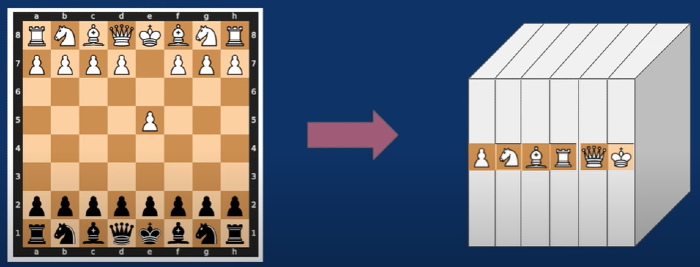

Voyons maintenant comment nous pouvons transformer l'ensemble de données brutes de Kaggle en ce type de représentation.

In [ ]:
with open('/content/chess_games.csv', newline='') as csvfile:
    # Create a CSV reader object
    csv_reader = csv.reader(csvfile)

    # Read the first row
    first_row = next(csv_reader)
    second_row = next(csv_reader)

    # Print the first row
    print(first_row)
    print(second_row)

['Event', 'White', 'Black', 'Result', 'UTCDate', 'UTCTime', 'WhiteElo', 'BlackElo', 'WhiteRatingDiff', 'BlackRatingDiff', 'ECO', 'Opening', 'TimeControl', 'Termination', 'AN']
[' Classical ', 'eisaaaa', 'HAMID449', '1-0', '2016.06.30', '22:00:01', '1901', '1896', '11.0', '-11.0', 'D10', 'Slav Defense', '300+5', 'Time forfeit', '1. d4 d5 2. c4 c6 3. e3 a6 4. Nf3 e5 5. cxd5 e4 6. Ne5 cxd5 7. Qa4+ Bd7 8. Nxd7 Nxd7 9. Nc3 Nf6 10. Qb3 Be7 11. Nxd5 Qa5+ 12. Nc3 O-O 13. Be2 b5 14. O-O Rad8 15. Bd2 Qc7 16. Rac1 Qd6 17. Qc2 Qe6 18. Nb1 Bd6 19. a3 Nb6 20. Qc6 Nfd5 21. Ba5 Rc8 22. Qb7 Qh6 23. h3 Nc4 24. Bxc4 bxc4 25. Qxd5 Rfd8 26. Qxe4 Rd7 27. Bc3 Re7 28. Qf3 Re6 29. Nd2 Rf6 30. Qg4 Re8 31. Ne4 Rg6 32. Qd7 Rf8 33. Nxd6 Rxd6 34. Qc7 Rg6 35. Qh2 Re8 36. d5 f6 37. d6 Rd8 38. Rfd1 1-0']


Ici nous definissons 2 fonctions pour transformer l'echiquier en representation matricielle.

# FONCTIONS POUR L'ENCODAGE DU BOARD

In [ ]:
def board_2_rep(board):
  pieces = ['p','r','n','b','q','k']
  layers =[]
  for piece in pieces:
    layers.append(create_rep_layer(board,piece))
  board_rep = np.stack(layers)
  return board_rep

def create_rep_layer(board,type):
  s=str(board)
  s=re.sub(f'[^{type}{type.upper()} \n]', '.', s)
  s=re.sub(f'{type}','-1', s)
  s=re.sub(f'{type.upper()}','1', s)
  s=re.sub(f'\.','0', s)

  board_mat = []
  for row in s.split('\n'):
    row = row.split(' ')
    row = [int(x) for x in row]
    board_mat.append(row)

  return np.array(board_mat)

# REPRESENTATION DU MOVE

Nous devons également trouver un moyen de représenter un mouvement.

Habituellement, dans un réseau de neurones utilisé pour la classification, la sortie est un vecteur avec des 0 pour les classes incorrectes et 1 pour la classe correcte. Cependant, ce concept ne fonctionnerait pas bien ici car le nombre de mouvements légaux varie d'un plateau à l'autre. De plus, l'indice d'un mouvement dans le vecteur ne contient aucune information sur le mouvement lui-même, ce qui n'est pas idéal pour l'apprentissage.



Pour résoudre ce problème, j'ai opté pour une représentation du mouvement utilisant deux ensembles de matrices : l'un indique quelle pièce effectue le déplacement, et l'autre spécifie où elle se déplace. Ensuite, nous devons convertir le format de mouvement (format algebrique) reçu par la fonction en un format plus pratique (format UCI)

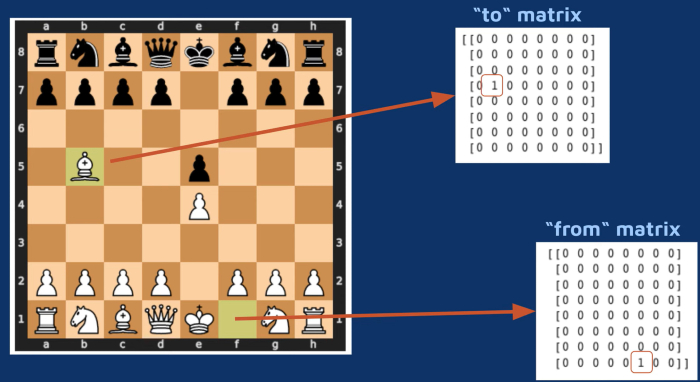

# FONCTIONS POUR L'ENCODAGE DU MOVE

In [ ]:

def move_2_rep(move,board):

  board.push_san(move).uci()
  move = str(board.pop())
#nous pouvons utiliser le coffre pour dictionnaire de métriques que nous avons
#créé plus tôt pour convertir un 0 en un 1 dans la position d'où la pièce se déplace

  from_output_layer = np.zeros((8,8))
  from_row = 8 - int(move[1])
  from_column = letter_2_num[move[0]]
  from_output_layer[from_row,from_column] =1

#nous retournons également un 0 à 1 sur l'autre matrice où la pièce se déplace,
  to_output_layer = np.zeros((8,8))
  to_row = 8- int(move[3])
  tow_column = letter_2_num[move[2]]
  to_output_layer[to_row,tow_column]=1

  return np.stack([from_output_layer,to_output_layer])

#Pour créer une liste des mouvements (format non encore transformé)
def create_move_list(s):
  return re.sub('\d*\. ','',s).split(' ')[:-1]



# GENERATION DU DATASET ET ENCODAGE

Rassemblons maintenant tout ce dont nous avons definie.

Nous commencerons par charger uniquement les colonnes dont nous avons besoin.

In [ ]:
#pour ne pas limiter l'affichage
pd.set_option('display.max_colwidth', None)

In [ ]:
#On charge les 2 colonnes pour les mouvements et la colonne de l'ELO (represente le niveau)
chess_data_raw = pd.read_csv('/content/chess_games.csv',usecols= ['AN','WhiteElo'])

print(chess_data_raw.columns)

Index(['WhiteElo', 'AN'], dtype='object')


On laisse que les parties dont le joueur blanc dispose d'un elo superieur à 2200 pour avoir des parties de meilleurs qualité


In [ ]:
print((chess_data_raw['WhiteElo'] > 2200).sum())
chess_data = chess_data_raw[chess_data_raw['WhiteElo']>2200]

276503


On supprime la colonne elo


In [ ]:
chess_data = chess_data[['AN']]

In [ ]:
chess_data = chess_data[~chess_data['AN'].str.contains('{')]

On supprime les parties trop courte


In [ ]:
chess_data = chess_data[chess_data['AN'].str.len() > 20]

print(chess_data.shape)
print(chess_data.iloc[0])

(237031, 1)
AN    1. e4 e6 2. d4 d5 3. Nc3 Bb4 4. e5 c5 5. a3 cxd4 6. Qxd4 Nc6 7. Bb5 Bxc3+ 8. Qxc3 Ne7 9. Bg5 O-O 10. O-O-O Bd7 11. Bxc6 Bxc6 12. Qg3 Qd7 13. Bxe7 Qxe7 14. f4 Rfc8 15. Nf3 Ba4 16. Nd4 Rc4 17. b3 Qxa3+ 18. Kb1 Rb4 19. f5 Bd7 20. f6 g6 21. h4 Rb6 22. Qe3 Qf8 23. h5 a5 24. hxg6 fxg6 25. Qh3 Qf7 26. Rd3 a4 27. Kb2 axb3 28. cxb3 Rba6 29. Qh6 Ra2+ 30. Kc3 Rc8+ 31. Kb4 Qf8+ 32. Qxf8+ Rxf8 33. Rdh3 Rf7 34. g4 Rd2 35. Nf3 Re2 36. Ng5 h5 37. Nxf7 Kxf7 38. gxh5 g5 39. h6 Kg8 40. h7+ Kh8 41. Rh6 Rxe5 42. Rg6 Re4+ 43. Ka3 Rh4 44. Rxh4 gxh4 45. Rg8+ Kxh7 46. Rg7+ Kh6 47. Rxd7 Kg6 48. f7 Kg7 49. f8=Q+ Kxf8 50. Rh7 h3 51. Rxh3 Kf7 52. Rh7+ Kf6 53. Rxb7 e5 54. Kb4 e4 55. Kc5 e3 56. Ra7 Ke5 57. Re7+ Kf4 58. Kxd5 1-0
Name: 39, dtype: object


Ici j'ai changé la classe ChessDataset je les transformé en fonction

In [ ]:
def create_chess_dataset(games):
    dataset = []
    for _ in range(40_000):
        game_i = np.random.randint(games.shape[0])
        random_game = games['AN'].values[game_i]
        moves = create_move_list(random_game)
        game_state_i = np.random.randint(len(moves) - 1)
        next_move = moves[game_state_i]
        moves = moves[:game_state_i]
        board = chess.Board()
        for move in moves:
            board.push_san(move)
        x = board_2_rep(board)
        y = move_2_rep(next_move, board)
        if game_state_i % 2 == 1:
            x *= -1
        dataset.append((x, y))
    return dataset

On instantie le data set


In [ ]:
data_train = create_chess_dataset(chess_data)

On affiche la nouvelle representation

In [ ]:
print(data_train[0])

On instancie le data loader avec les  hyper parametres desirés.

Ici le shuffle n'est pas necessaire parceque les parties sont deja selectionné randomly, le drop_last parametre va jeter le dernier batch s'il y a pas suffisement d'exemplaire pour le creer

In [ ]:
data_train_loader = DataLoader(data_train, batch_size = 32, shuffle = True, drop_last = True)

# CONSTRUCTION DU RESEAU DE NEURONNES



On definit un module qui sera reproductible, il contient deux couches de convolution, deux couches de normalisation par lots pour améliorer l'entraînement, et deux fonctions d'activation zéro qui donnent généralement de très bons résultats. De plus, la fonction de propagation contient une connexion résiduelle où l'entrée est ajoutée à la sortie, ce qui a été démontré pour améliorer le processus d'entraînement.

In [ ]:
# Define module components as functions
def create_module(hidden_size):
    conv1 = nn.Conv2d(hidden_size, hidden_size, 3, stride=1, padding=1)
    conv2 = nn.Conv2d(hidden_size, hidden_size, 3, stride=1, padding=1)
    bn1 = nn.BatchNorm2d(hidden_size)
    bn2 = nn.BatchNorm2d(hidden_size)
    activation1 = nn.SELU()
    activation2 = nn.SELU()

    def forward(x):
        x_input = torch.clone(x)
        x = conv1(x)
        x = bn1(x)
        x = activation1(x)
        x = conv2(x)
        x = bn2(x)
        x = x + x_input
        x = activation2(x)
        return x

    return nn.Sequential(conv1, bn1, activation1, conv2, bn2, activation2)  # Return a module instance

En dehors d'une couche d'entrée et d'une couche de sortie, le réseau entier se compose 4 modules les uns après les autres. L'utilisation de la fonction NN.ModuleList pour créer efficacement plusieurs modules. Si on utilise la fonction NN.module régulière, les paramètres du module ne seront pas reconnus par l'ensemble du réseau et ne seront pas mis à jour pendant le processus d'entraînement.

In [ ]:
# Define ChessNet components as functions
def ChessNet(hidden_layers=4, hidden_size=200):
    input_layer = nn.Conv2d(6, hidden_size, 3, stride=1, padding=1)
    output_layer = nn.Conv2d(hidden_size, 2, 3, stride=1, padding=1)

    # Create actual module instances
    module_list = [create_module(hidden_size) for _ in range(hidden_layers)]

    # Flatten the module list and collect parameters
    all_layers = [input_layer] + module_list + [output_layer]
    all_params = [
        {'params': input_layer.parameters()},
        {'params': output_layer.parameters()}
    ]
    for module_instance in module_list:
        all_params.extend({'params': param} for param in module_instance.parameters())

    return nn.Sequential(*all_layers), all_params

In [ ]:
# Initialize model components
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

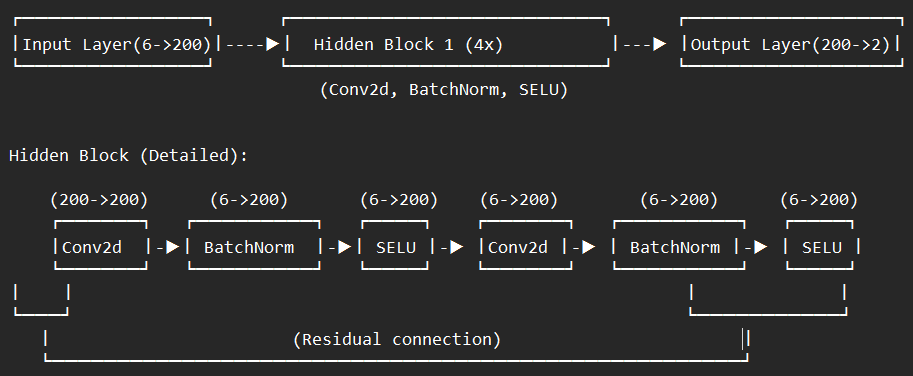

In [ ]:
# Create model
ChessNet_model, all_params = ChessNet(hidden_layers=4, hidden_size=200)
ChessNet_model.to(device)  # Move model to device

In [ ]:
# Create the optimizer
optimizer = optim.Adam(all_params, lr=0.001)  # Define optimizer

# ENTRAINEMENT DU MODEL




La boucle d'entraînement est très basique, la seule chose unique à son sujet est le fait que j'ai utilisé des pertes distinctes pour les feature map. La raison en est que la sortie du réseau doit être interpolée comme deux distributions de probabilité distinctes : l'une pour choisir quelle pièce utiliser et l'autre pour décider quoi en faire.
Puisque la cross-entropy est conçue pour fonctionner avec une seule distribution de probabilité, nous avions besoin de deux d'entre elles pour gérer les deux distributions de probabilité de sortie.


J'ai choisis 10 epochs car en utilisant le early stopping le training ne voulais pas s'arreter, ça a pris toute une journée et ça c'est arreté brutalement

In [ ]:
# Define your loss functions
metric_from = nn.CrossEntropyLoss()
metric_to = nn.CrossEntropyLoss()

# Number of training epochs
num_epochs = 10

# Training loop
for epoch in range(num_epochs):
    total_loss = 0.0

    # Iterate over the dataset
    for batch_idx, (input_data, target_data) in enumerate(data_train_loader):
        optimizer.zero_grad()  # Zero the gradients

        # Move input data to GPU
        input_data, target_data = input_data.to(device), target_data.to(device)
        input_data = input_data.float()

        # Forward pass
        output = ChessNet_model(input_data)

        # Calculate losses
        loss_from = metric_from(output[:, 0, :], target_data[:, 0, :])
        loss_to = metric_to(output[:, 1, :], target_data[:, 1, :])
        loss = loss_from + loss_to

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        total_loss += loss.item()

    # Print average loss for the epoch
    average_loss = total_loss / len(data_train_loader)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}')

print('Training finished.')


cuda
Epoch [1/10], Loss: 0.2401
Epoch [2/10], Loss: 0.1966
Epoch [3/10], Loss: 0.1839
Epoch [4/10], Loss: 0.1747
Epoch [5/10], Loss: 0.1669
Epoch [6/10], Loss: 0.1601
Epoch [7/10], Loss: 0.1540
Epoch [8/10], Loss: 0.1479
Epoch [9/10], Loss: 0.1424
Epoch [10/10], Loss: 0.1370
Training finished.


In [ ]:
# Save the model
torch.save(ChessNet_model.state_dict(), 'chessnet_model.pth')

Pour choisir un mouvement, on ne peut pas simplement sélectionner la position de probabilité la plus élevée de chaque sortie, car le mouvement optimal peut être illégal ou on peut souhaiter introduire une certaine aléatoire dans le processus. Pour résoudre cela, on peut utiliser les fonctions suivantes.

In [ ]:
# Fonction pour vérifier si un seul coup donne Échec et mat
def check_mate_single(board):
    board = board.copy()
    legal_moves = list(board.legal_moves)
    for move in legal_moves:
        board.push_uci(str(move))
        if board.is_checkmate():
            move = board.pop()
            return move
        _ = board.pop()

Ici nou definissions une fonction qui prend une liste de nombres et les convertit en une distribution de probabilités. Tout d'abord, nous appliquons une fonction softmax, qui nous donne une distribution. Ensuite, nous élevons cette distribution au cube et la normalisons à nouveau.

Cela signifie que les coups ayant initialement des évaluations élevées seront davantage favorisés après l'application de cette fonction, tandis que les évaluations faibles seront moins probables, mais il y aura toujours une certaine aléatoire dans le choix final.

In [ ]:
def distribution_over_moves(vals):
    #softmax
    probs = np.array(vals)
    probs = np.exp(probs)
    probs = probs / probs.sum()

    probs = probs ** 3
    probs = probs / probs.sum()
    return probs

On definit aussi 2 fonctions pour choisir un coup à jouer la premiere pour prédire les coups à partir de l'état du plateau et la deuxieme pour choisir un coup à jouer

In [ ]:
def predict(x):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        output = model(x)

    return output[:, 0, :, :], output[:, 1, :, :]

# CHOIX DU MOVE ET DECODAGE

In [ ]:
def choose_move(board, player, color):
    legal_moves = list(board.legal_moves)
    move = check_mate_single(board)
    if move is not None:
        return move

    x = torch.Tensor(board_2_rep(board)).float().unsqueeze(0).to('cpu')
    if color == chess.BLACK:
        x *= -1

    move_from, move_to = predict(x)
    move_from_cpu = move_from.cpu().numpy()
    move_to_cpu = move_to.cpu().numpy()

    vals = []
    froms = [str(legal_move)[:2] for legal_move in legal_moves]
    froms = list(set(froms))


    # for each unique legal starting position we'll take the value the network assigned to it and make a move from that position
    for from_ in froms:
        val = move_from_cpu[0, :, :][8 - int(from_[1]), letter_2_num[from_[0]]]
        vals.append(val)

    probs = distribution_over_moves(vals)

    chosen_from = str(np.random.choice(froms, size=1, p=probs)[0])[:2]
    vals = []
    for legal_move in legal_moves:
        from_ = str(legal_move)[:2]
        if from_ == chosen_from:
            to = str(legal_move)[2:]
            val = move_to_cpu[0, :, :][8 - int(to[1]), letter_2_num[to[0]]]
            vals.append(val)
        else:
            vals.append(0)
    chosen_move = legal_moves[np.argmax(vals)]
    return chosen_move



* **Test du modèle**

On essaye le modele pour qu'il puisse jouer contre lui meme

In [ ]:

model = model.to('cpu')
# Initialize the chess board
board = chess.Board()

# Set the player and color
player = "White"  # Replace with your player name
color = chess.WHITE  # or chess.BLACK

# Play a series of moves to simulate a game
num_moves_to_play = 10  # Adjust the number of moves as needed

for _ in range(num_moves_to_play):
    # Display the current board position
    print(board)

    # Choose a move using the trained model
    chosen_move = choose_move(board, player, color)

    # Print the move
    print(f"{player} plays: {chosen_move}")

    # Make the chosen move on the board
    board.push(chosen_move)

    # Switch player color for the next move
    color = not color

# Display the final board position
print("Final board position:")
print(board)


r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
P P P P P P P P
R N B Q K B N R
White plays: d2d4
r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . P . . . .
. . . . . . . .
P P P . P P P P
R N B Q K B N R
White plays: d7d5
r n b q k b n r
p p p . p p p p
. . . . . . . .
. . . p . . . .
. . . P . . . .
. . . . . . . .
P P P . P P P P
R N B Q K B N R
White plays: e2e3
r n b q k b n r
p p p . p p p p
. . . . . . . .
. . . p . . . .
. . . P . . . .
. . . . P . . .
P P P . . P P P
R N B Q K B N R
White plays: c7c6
r n b q k b n r
p p . . p p p p
. . p . . . . .
. . . p . . . .
. . . P . . . .
. . . . P . . .
P P P . . P P P
R N B Q K B N R
White plays: g1e2
r n b q k b n r
p p . . p p p p
. . p . . . . .
. . . p . . . .
. . . P . . . .
. . . . P . . .
P P P . N P P P
R N B Q K B . R
White plays: g8f6
r n b q k b . r
p p . . p p p p
. . p . . n . .
. . . p . . . .
. . . P . . . .
. . . . P . . .
P P P . N P P P
R N B Q K B 

In [ ]:
model = model.to('cuda')  # Move the model to GPU

# Define a sample chess board as input
board = chess.Board()
x = torch.Tensor(board_2_rep(board)).float().unsqueeze(0).to(device)

def predict(x):
    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        output = model(x)

    return output

# Test the predict function
output = predict(x)

# Print the output
print("Output Tensor:")
print(output)

Output Tensor:
tensor([[[[ -9.9344,  -9.4445, -11.8072, -17.0807, -13.4304, -12.3812, -10.3253,
           -13.8753],
          [ -8.8898, -16.4713, -17.1583, -11.6267, -14.3584, -19.4217, -17.8883,
           -13.1398],
          [ -2.1838,  -8.8430,  -7.7988,  -8.2493,  -9.0523, -10.0990,  -8.8197,
            -4.0206],
          [ -5.8575,  -8.3820,  -7.6831,  -7.8019,  -7.3186,  -8.3441,  -6.8178,
            -4.1649],
          [ -3.5450,  -2.7814,  -4.9205,  -5.0043,  -4.3592,  -2.9527,  -1.8152,
            -2.6896],
          [ -0.7192,   0.0698,  -0.6744,   1.8297,   0.6764,   0.2697,  -1.3188,
            -0.5038],
          [ 10.3570,  11.3964,  12.7702,  14.6717,  13.6904,  13.1128,  12.2323,
            11.3273],
          [  7.2494,  12.2074,   7.6849,   8.3065,   5.7453,   9.9492,  14.0094,
             4.4139]],

         [[  1.2329,  -1.8124,  -2.0521,  -0.9619,  -4.7670,  -2.2397,  -1.8383,
            -0.6788],
          [ -0.6806,  -0.2644,  -1.5016,  -3.7180,  -4.3

In [ ]:
# Convert the output to probabilities using softmax
probs = torch.nn.functional.softmax(output, dim=1)

# Print the probabilities
print("\nProbabilities:")
print(probs)



Probabilities:
tensor([[[[1.4129e-05, 4.8441e-04, 5.7995e-05, 9.9922e-08, 1.7277e-04,
           3.9410e-05, 2.0609e-04, 1.8572e-06],
          [2.7205e-04, 9.1505e-08, 1.5862e-07, 3.6739e-04, 4.5652e-05,
           1.0810e-08, 1.0335e-07, 1.2386e-05],
          [9.8287e-01, 1.5867e-01, 2.8863e-01, 1.1351e-01, 3.2392e-02,
           2.1278e-02, 5.4962e-02, 7.1750e-01],
          [5.4304e-03, 1.9679e-04, 7.8204e-02, 1.1844e-02, 1.4024e-02,
           3.8227e-02, 1.3712e-03, 8.4607e-03],
          [2.4681e-04, 3.0030e-02, 5.1494e-05, 4.0473e-05, 7.0889e-05,
           2.9351e-03, 3.1803e-01, 1.7186e-03],
          [8.8358e-03, 1.4269e-02, 6.6420e-03, 2.5959e-01, 1.2428e-01,
           2.5211e-03, 6.1721e-03, 1.6441e-02],
          [1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
           1.0000e+00, 1.0000e+00, 1.0000e+00],
          [9.9986e-01, 1.0000e+00, 9.9993e-01, 9.9999e-01, 9.9980e-01,
           1.0000e+00, 1.0000e+00, 9.9356e-01]],

         [[9.9999e-01, 9.9952e

# TEST DU MODEL CONTRE STOCKFISH



---



On definie tout ce qu'il faut et on importe le model

In [ ]:
import pandas as pd
import numpy as np
import chess
import re
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
import chess.svg

letter_2_num = {'a':0,'b':1,'c':2,'d':3,'e':4,'f':5,'g':6,'h':7}
num_2_letter = {0:'a',1:'b',2:'c',3:'d', 4:'e',5:'f', 6:'g', 7:'h'}
def create_rep_layer(board,type):
  s=str(board)
  s=re.sub(f'[^{type}{type.upper()} \n]', '.', s)
  s=re.sub(f'{type}','-1', s)
  s=re.sub(f'{type.upper()}','1', s)
  s=re.sub(f'\.','0', s)

  board_mat = []
  for row in s.split('\n'):
    row = row.split(' ')
    row = [int(x) for x in row]
    board_mat.append(row)

  return np.array(board_mat)
def board_2_rep(board):
  pieces = ['p','r','n','b','q','k']
  layers =[]
  for piece in pieces:
    layers.append(create_rep_layer(board,piece))
  board_rep = np.stack(layers)
  return board_rep
def move_2_rep(move,board):

  board.push_san(move).uci()
  move = str(board.pop())

  from_output_layer = np.zeros((8,8))
  from_row = 8 - int(move[1])
  from_column = letter_2_num[move[0]]
  from_output_layer[from_row,from_column] =1

  to_output_layer = np.zeros((8,8))
  to_row = 8- int(move[3])
  tow_column = letter_2_num[move[2]]
  to_output_layer[to_row,tow_column]=1

  return np.stack([from_output_layer,to_output_layer])
def create_move_list(s):
  return re.sub('\d*\. ','',s).split(' ')[:-1]
class module(nn.Module):
  def __init__(self,hidden_size):
    super(module,self).__init__()
    self.conv1 = nn.Conv2d(hidden_size,hidden_size,3, stride =1,padding =1)
    self.conv2 = nn.Conv2d(hidden_size,hidden_size,3, stride =1,padding =1)
    self.bn1 = nn.BatchNorm2d(hidden_size)
    self.bn2 = nn.BatchNorm2d(hidden_size)
    self.activation1 = nn.SELU()
    self.activation2 = nn.SELU()
#input is added to tho output so it inproves the results
  def forward(self,x):
    x_input = torch.clone(x)
    x= self.conv1(x)
    x= self.bn1(x)
    x = self.activation1(x)
    x= self.conv2(x)
    x= self.bn2(x)
    x= x + x_input
    x=self.activation2(x)
    return x
class ChessNet(nn.Module):
  def __init__(self,hidden_layers=4,hidden_size=200):
    super(ChessNet ,self).__init__()
    self.hidden_layers = hidden_layers
    self.input_layer = nn.Conv2d(6,hidden_size,3,stride=1,padding=1)
    self.module_list = nn.ModuleList([module(hidden_size) for i in range(hidden_layers)])
    self.output_layer = nn.Conv2d(hidden_size,2,3,stride=1,padding=1)

  def forward(self,x):
    x=self.input_layer(x)
    x=F.relu(x)

    for i in range(self.hidden_layers):
      x = self.module_list[i](x)

    x= self.output_layer(x)
    return x

# Specify a path
PATH = "./model.pt"

# Load the model onto the CPU
model = ChessNet()
model.load_state_dict(torch.load(PATH, map_location=torch.device('cpu')))
model.eval()

def check_mate_single(board):
    board = board.copy()
    legal_moves = list(board.legal_moves)
    for move in legal_moves:
        board.push_uci(str(move))
        if board.is_checkmate():
            move = board.pop()
            return move
        _ = board.pop()
def distribution_over_moves(vals):
    probs = np.array(vals)
    probs = np.exp(probs)
    probs = probs / probs.sum()
    probs = probs ** 3
    probs = probs / probs.sum()
    return probs
def predict(x):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        output = model(x)

    return output[:, 0, :, :], output[:, 1, :, :]

def choose_move(board, player, color):
    legal_moves = list(board.legal_moves)
    move = check_mate_single(board)
    if move is not None:
        return move

    x = torch.Tensor(board_2_rep(board)).float().unsqueeze(0).to('cpu')
    if color == chess.BLACK:
        x *= -1

    move_from, move_to = predict(x)
    move_from_cpu = move_from.cpu().numpy()
    move_to_cpu = move_to.cpu().numpy()

    vals = []
    froms = [str(legal_move)[:2] for legal_move in legal_moves]
    froms = list(set(froms))

    # for each unique legal starting position we'll take the value the network assigned to it and make a move from that position
    for from_ in froms:
        val = move_from_cpu[0, :, :][8 - int(from_[1]), letter_2_num[from_[0]]]
        vals.append(val)

    probs = distribution_over_moves(vals)

    chosen_from = str(np.random.choice(froms, size=1, p=probs)[0])[:2]
    vals = []
    for legal_move in legal_moves:
        from_ = str(legal_move)[:2]
        if from_ == chosen_from:
            to = str(legal_move)[2:]
            val = move_to_cpu[0, :, :][8 - int(to[1]), letter_2_num[to[0]]]
            vals.append(val)
        else:
            vals.append(0)
    chosen_move = legal_moves[np.argmax(vals)]
    return chosen_move

* **Contre stockfish**

In [ ]:
class ChessGUI:
    def __init__(self, model):
        self.board = chess.Board()
        self.model = model
        self.stockfish = Stockfish("C:\\Users\\User\\Downloads\\stockfish-windows-x86-64-avx2\\stockfish\\stockfish-windows-x86-64-avx2.exe")
        self.games_played = 0

    def play_game(self):
        player_name = "YourPlayerName"
        while not self.board.is_game_over():
            if self.board.turn == chess.WHITE:
                # Model's move
                chosen_move = choose_move(self.board, player_name, chess.WHITE)
            else:
                # Stockfish's move
                self.stockfish.set_fen_position(self.board.fen())
                chosen_move_uci = self.stockfish.get_best_move()
                chosen_move = chess.Move.from_uci(chosen_move_uci)

            # Make the chosen move on the board
            self.board.push(chosen_move)

        # Check the result of the game
        if self.board.result() == '1-0':
            print(f"White wins after {self.games_played} games!")
            return True
        elif self.board.result() == '0-1':
            print(f"Black wins after {self.games_played} games!")
            return False
        else:
            print(f"It's a draw after {self.games_played} games!")
            return False

        # Increment the number of games played
        self.games_played += 1

# Create an instance of ChessGUI
chess_gui = ChessGUI(model)

# Play the game
while not chess_gui.play_game():
    pass


* **Jouer contre le model**

In [ ]:
from IPython.display import display, HTML, clear_output

class ChessGUI:
    def __init__(self, model):
        self.board = chess.Board()
        self.model = model

    def display_board(self):
        display(HTML(chess.svg.board(board=self.board, size=700)))

    def play_game(self, num_moves_to_play=200):
        player_name = "YourPlayerName"
        for move_num in range(num_moves_to_play):
            if self.board.turn == chess.WHITE:
                # Model's move
                chosen_move = choose_move(self.board, player_name, chess.WHITE)
            else:
                # Your move
                valid_move = False
                while not valid_move:
                    move_uci = input(f"Enter your move in UCI format (e.g., e7e5): ")
                    try:
                        chosen_move = chess.Move.from_uci(move_uci)
                        valid_move = chosen_move in self.board.legal_moves
                        if not valid_move:
                            print("Invalid move. Please enter a valid move.")
                    except ValueError:
                        print("Invalid move format. Please enter a valid move in UCI format.")

            # Make the chosen move on the board
            self.board.push(chosen_move)

            # Clear the output to remove previous board display
            clear_output(wait=True)

            # Display the board after the move
            self.display_board()

            # Print the move
            print(f"{player_name} plays: {chosen_move}")

# Initialize the Chess GUI with the trained model
chess_gui = ChessGUI(model)

# Play the game
chess_gui.play_game()
